# MNIST Digit Recognizer Neural Network

My first attempt at running the MNIST digit image data through scikit's RandomForestClassifier hit an accuracy around 96%, which I'd like to improve upon.  As noted before, the image data are pretty diverse, coming as they do from a pretty diverse group of examples of human handwriting, and it's entirely possible that a more sophisticated machine learning approach could generate a better model to predict the digit labels from the pixels.

The basic properties of neural networks have been summarized [elsewhere](https://www.youtube.com/playlist?list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU); suffice it to say that they constitute a series of nodes and edges representing greatly simplified virtual analogs of actual neurons in an animal brain.  The nodes are arranged in layers, with an input layer (here with one node per pixel of the train/test data), an output layer (with 10 nodes, each representing the strength of prediction that the entire digit represents the number 0, the number 1, etc.), and one or more hidden layers, where the inputs are "weighed" and integrated, to determine if the "neuron" will "fire" (i.e., how strong of a signal it sends along to the next layer, and ultimately to the output layer).

The machine learning comes in varying the weights that represent the edges of the network; deciding how strong the association between each input pixel, hidden layer neuron, and output digit should be.  The algorithm decides this on the basis of "backpropagating" the error between the digit's label and the model's output call; obtaining the derivative of a particular weight with respect to the error function, to tell in a computationally-tractable manner whether increasing or decreasing that weight will render an output call that's closer to the label.  The output model is just a list of list of weights, telling which associations between neurons represents the best way to transition from input to output.

That's all done by the algorithm; in this notebook I'm just trying to get a handle on the "hyperparameters" of the method: how will tweaking the various arguments of sklearn's multilayer perceptron classifier affect the accuracy of the predictions?  What results is an empirical (read: theory-poor) dive into cranking every little knob on this machine, to see how pretty the outcome can be.  [Spoiler alert: nothing I do makes a big difference, but it was still educational to try.]

I'll start by copying over the relevant code from my RandomForest notebook to import and split the data.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import clock
import random
from itertools import combinations, repeat
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
%matplotlib inline

In [4]:
%%time

# on the PC:
# train = pd.read_csv('C:\\Users\\DMacKellar\\Documents\\Python\\Kaggle\\Digit\\train.csv')

# test = pd.read_csv('C:\\Users\\DMacKellar\\Documents\\Python\\Kaggle\\Digit\\test.csv')

# on the Mac:
train = pd.read_csv('/Users/drew/Documents/Data/R/Kaggle_Digit_Recognizer/train.csv')

test = pd.read_csv('/Users/drew/Documents/Data/R/Kaggle_Digit_Recognizer/test.csv')

CPU times: user 10.3 s, sys: 1.77 s, total: 12.1 s
Wall time: 19.1 s


## Part 1: Rescale the data

I learned pretty quickly that Neural Network approaches don't work well with the raw data (integers between 0 and 255); they need to be rescaled, and I choose to rescale all pixel values to floats between 0 and 1.

In [9]:
train2 = train.iloc[:,1:].apply(lambda x: x / 255)
train3 = pd.concat([train.iloc[:,0], train2], axis=1, join='inner')
train3.iloc[0:5,0:7]

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5
0,1,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0


I'll take a quick look at the columns, plotting their maximal pixel intensities:

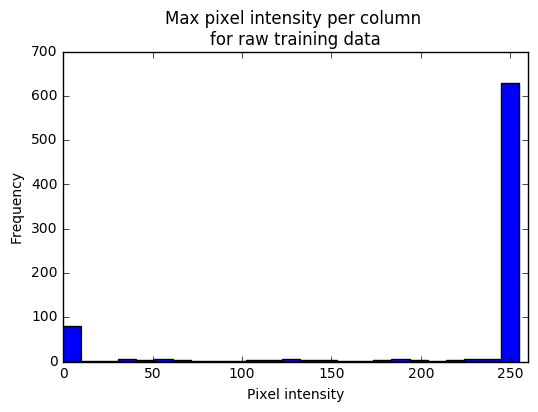

In [5]:
plt.hist(train.iloc[:,1:].max(), bins=25)
plt.title('Max pixel intensity per column \nfor raw training data')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.xlim(0, 260)
plt.show()

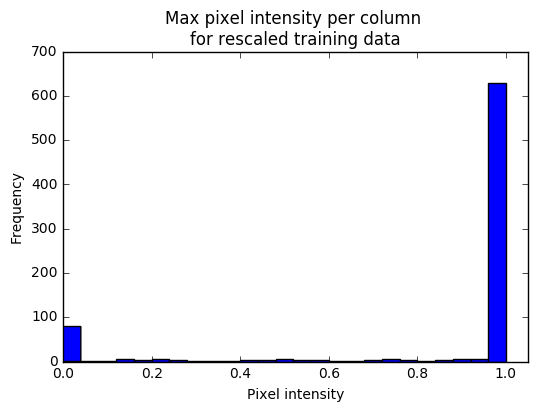

In [6]:
plt.hist(train3.iloc[:,1:].max(), bins=25)
plt.title('Max pixel intensity per column \nfor rescaled training data')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.xlim(0, 1.05)
plt.show()

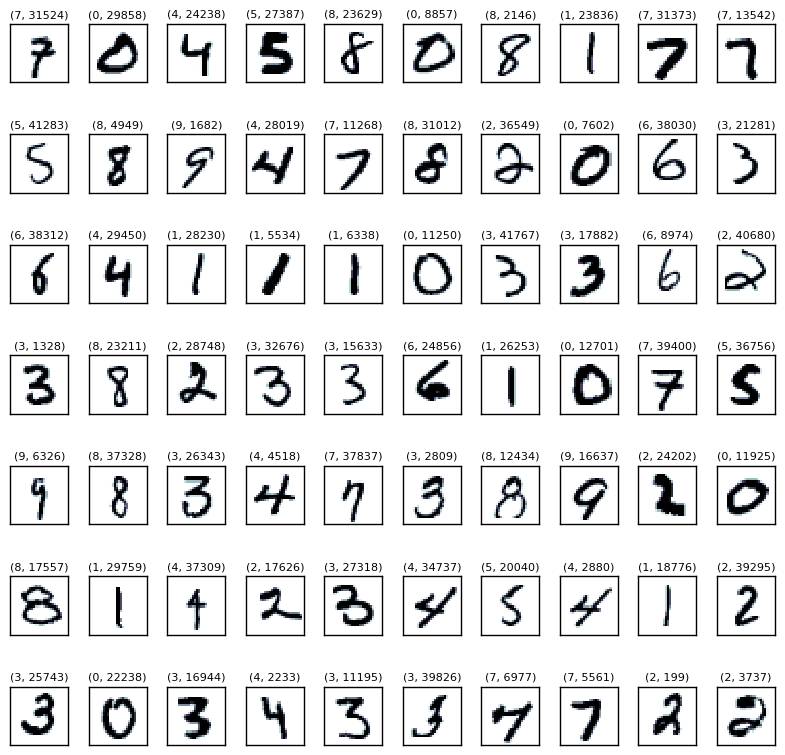

In [6]:
# just to check the rescaled data still make sense visually
subplot1 = 1
plt.figure(figsize=(8, 8))
for digit in random.sample(range(len(train3)), 70):
    plt.subplot(7, 10, subplot1)
    grid_data = train3.iloc[digit, 1:].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "bone_r")
    title = int(train3.iloc[digit, 0])
    plt.title((title, digit), fontsize=8)
    plt.xticks([])
    plt.yticks([])
    subplot1 += 1
plt.tight_layout()
plt.show()

Of course the test data set doesn't have labels, so it can be rescaled directly.

In [26]:
test2 = test.apply(lambda x: x / 255)

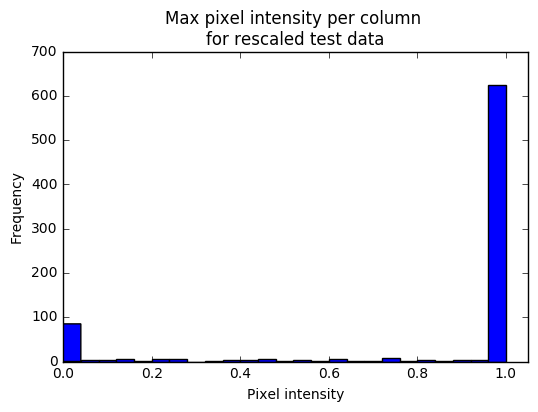

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
plt.hist(test2.max(), bins=25)
plt.xlim(0, 1.05)
plt.title('Max pixel intensity per column \nfor rescaled test data')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.show()
test2.iloc[0:5,0:7]

## Part 2: First pass with MLPClassifier

There are several different flavors of neural networks, in addition to the different hyperparameters that can be set within any given approach.  From scikit-learn's [page](http://scikit-learn.org/stable/modules/neural_networks_supervised.html), it sounds as though the first listed kind, a multi-layer perceptron classifier, would be a good place to start.

Let's try a first pass using the a sample with 4,000 rows for training, and 1,000 rows for testing.  I'll just stick with default settings for now.

In [6]:
%%time

clf = MLPClassifier()
clf.fit(train3.iloc[0:4000, 1:], train3.iloc[0:4000, 0])
print(clf.score(train3.iloc[4001:5000, 1:], train3.iloc[4001:5000, 0]))

0.934934934935
CPU times: user 36.6 s, sys: 5.31 s, total: 41.9 s
Wall time: 22.1 s


In [64]:
print(clf)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


Ok, 93% accuracy out of the box: not bad.  

## Part 3: Digging deeper

The major choices in a neural network are the number of hidden layers desired, the number of neurons per hidden layer, the choice of backpropagation approach, the activation function applied at each neuron, the size of the steps by which to vary the weights in each iteration, the increase in the score/decrease in the penalty of the difference between the output and the objective function that will be tolerated before you stop iterating, the size of the regularization parameter (to avoid overfitting), and perhaps others that I haven't thought of yet.

According to print(clf), the default settings are:

activation = ['relu'](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
The other alternatives are 'identity', 'logistic', and 'tanh'.

alpha = 1e-4 
This is the regularization term: the penalty applied to weights varying too much.  It is essentially attempting to reduce the likelihood of overfitting.  This may be something I could try tweaking, but it's not a high priority

batch_size = 'auto'
"Size of minibatches for stochastic optimizers."

beta_1 = 0.9
"Exponential decay rate for estimates of first moment vector in adam"

beta_2 = 0.999
"Exponential decay rate for estimates of second moment vector in adam"

early_stopping = False  
Whether to stop iterating (prior to max_iter or convergence to tol) if score isn't improving.  "Only effective when solver='sgd' or 'adam'"

epsilon = 1e-8
"Value for numerical stability in adam"

<b>hidden_layer_sizes = (100,) 
Sounds like 100 neurons in a single hidden layer.  Definitely something to try tweaking.</b>

<b>learning_rate = 'constant'  
"Only used when solver='sgd'"</b>

learning_rate_init = 0.001  
"Only used when solver='sgd' or 'adam'"

max_iter = 200  
Might be worth playing with, but lower priority than hidden layer size or solver

momentum = 0.9  
Momentum for gradient descent update; "only used when solver='sgd'".

nesterovs_momentum = True  
"Only used when solver='sgd' and momentum>0"

power_t = 0.5  
When sgd solver is used: "effective_learning_rate = learning_rate_init / pow(t, power_t)"

random_state = None  
Just the seed for a pseudorandom number generator.

shuffle = True  
Used with solver='sgd' or 'adam' to change the sample order when drawing inputs to train the network.

<b>solver = 'adam'  
"The default solver [‘adam’](https://arxiv.org/abs/1412.6980) works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better."  It sounds like adam is a special case of 'sgd', which is just stochastic gradient descent.</b>

tol = 0.0001  
"Tolerance for the optimization. When the loss or score is not improving by at least tol for two consecutive iterations, unless learning_rate is set to ‘adaptive’, convergence is considered to be reached and training stops."  This could be a biggie; lots of reasons networks may get stuck in local energy minima.  Maybe need an adaptive learning rate, and then playing with the rate_init.

validation fraction = 0.1  
The proportion of training data to set aside for early stopping.  Only used if early_stopping is true.

verbose = False  
Whether or not to spit info out to the terminal during training.

warm_start = False  
If set to True, clf.fit() will start with the output weights matrix of the previous clf.fit() call.  Probably leave off.

---

I don't want to try playing with all of these parameters, but some of them are definitely targets for seeing if I can improve on the performance above.  My approach will be to leave all options on their default settings until I try permuting a particular option; at that point, I will leave that option on the best setting that I find for all future train/test cycles.  I will stick with 4,000 samples for training and 1,000 for testing.  My priorities for options to try changing are, in order:

* Hidden layer size(s)
* Solver
* Learning rate (if sgd chosen for solver)
* Activation function
* Alpha
* Tol

## Part 4: Hidden layer size


It definitely seems that the hidden layer size and overall shape of the network is the first thing to change.  I'm having difficulty interpreting the description of that argument's format from the docs, which say:

hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
The ith element represents the number of neurons in the ith hidden layer.

In [73]:
print(clf.n_layers_)
print(clf.classes_, clf.n_outputs_)
print(len(clf.coefs_), len(clf.coefs_[0]), len(clf.coefs_[1]))
print(len(clf.coefs_[0][1]))

3
[0 1 2 3 4 5 6 7 8 9] 10
2 784 100
100


So the argument "hidden_layer_sizes=(100,)" in the MLPClassifier call that defined clf did indeed end up with just 3 layers: inputs, one hidden layer, and one output.

-The inputs are 784 pixels from each digit, and have no weights, activation function, or inputs that went in to generating them.  

-There is one hidden layer with 100 neurons, each of which has inputs from all 784 pixels, meaning there are 784 coefficients defining the weights leading from each input node to each neuron.

-Put another way, the first layer of the coefficients matrix has 784 lists, representing each pixel of the input image as a node in the input layer.  Each of these 784 lists has 100 floats within it, representing 100 different weights leading from that node to the 100 different neurons of the hidden layer.

-The final layer is the output layer, with 10 neurons/nodes, to weigh in on which of the 10 possible digits the image most likely represents.  Each of these neurons receives inputs from each of the 100 neurons of the hidden layer.  So the second layer of the coefficients matrix has 100 lists, and each of those lists has 10 elements, representing the 10 different weights leading from each node of the hidden layer to each node of the output layer.

So the total number of nodes in the network should be:
1 * 784 + 1 * 100 + 1 * 10 = 894
and the number of edges (the coefficients present in the matrix defining the weights of the final model) should be:
0 X 784 + 784 X 100 + 10 X 100 = 79,400

In [10]:
print(len(clf.coefs_[0]) * len(clf.coefs_[0][0]) + len(clf.coefs_[1]) * len(clf.coefs_[1][0]))

79400


Clearly, when it comes to selecting the network topology, this is an in-depth topic that involves a lot of opinion and empiricism, but [one discussion on stackexchange](http://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) was readable and offered some concrete tips.

One was to take 2/3rds the number of input neurons plust the number of output neurons.  That would be 784/3 + 10: 271.
Another was to apply the formula taking a ratio of the number of samples in the training set to the product of an arbitrary scaling factor between 2 and 10 (with 2 being suggested) and the sum of the input and output layer neurons.  This would be 42000/(2 * (784 + 10)) = 26.

Both suggested a single hidden layer would probably be enough in most cases.  The discussion did hinge somewhat on tradeoffs between accuracy and computational performance, and the latter is not a consideration in my case because the nature of the Kaggle competition is to run the test data set locally and upload predictions, not to build a model that will either be modified in the future with new data, nor to judge a stream of new test data.  The more important consideration for network topology for me is overfitting or underfitting, rather than processor time, but this can be addressed through the extra factor of alpha, and its effect judged by judicious splitting of the training set.

I will simply try a range of hidden layer sizes and evaluating scores:

In [86]:
neurons_scores = []
sizes = list(range(10, 501, 10))
times = []
timer = clock()

for i in sizes:
    j = train3.sample(n=5000)
    clf = MLPClassifier(hidden_layer_sizes=(i,))
    clf.fit(j.iloc[:4000, 1:], j.iloc[:4000, 0])
    neurons_scores.append(clf.score(j.iloc[4001:, 1:], j.iloc[4001:, 0]))
    times.append(round(clock() - timer, 3))
    print('Number of hidden layer neurons: ', i, '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

C:\Python\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Number of hidden layer neurons:  10 	Time taken:  8.49  seconds
Number of hidden layer neurons:  20 	Time taken:  9.44  seconds
Number of hidden layer neurons:  30 	Time taken:  9.284  seconds
Number of hidden layer neurons:  40 	Time taken:  8.681  seconds
Number of hidden layer neurons:  50 	Time taken:  8.822  seconds
Number of hidden layer neurons:  60 	Time taken:  8.952  seconds
Number of hidden layer neurons:  70 	Time taken:  10.621  seconds
Number of hidden layer neurons:  80 	Time taken:  10.215  seconds
Number of hidden layer neurons:  90 	Time taken:  11.309  seconds
Number of hidden layer neurons:  100 	Time taken:  10.377  seconds
Number of hidden layer neurons:  110 	Time taken:  14.359  seconds
Number of hidden layer neurons:  120 	Time taken:  11.048  seconds
Number of hidden layer neurons:  130 	Time taken:  12.061  seconds
Number of hidden layer neurons:  140 	Time taken:  14.159  seconds
Number of hidden layer neurons:  150 	Time taken:  13.183  seconds
Number of hi

In [93]:
print(len(sizes), len(neurons_scores), len(times))

50 50 50


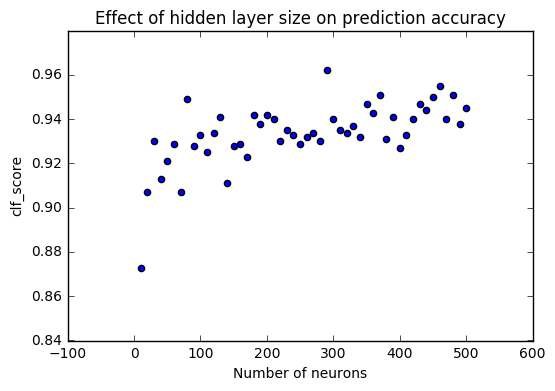

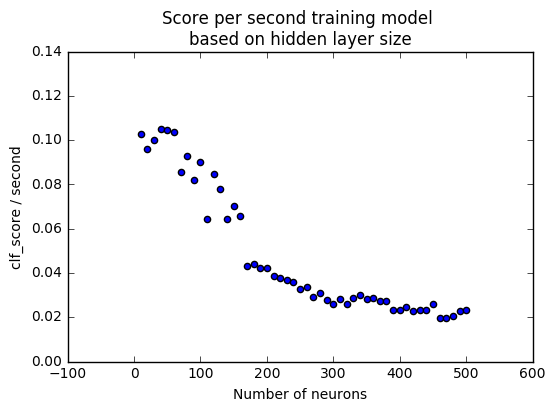

In [94]:
plt.scatter(sizes, neurons_scores)
plt.title('Effect of hidden layer size on prediction accuracy')
plt.xlabel('Number of neurons')
plt.ylabel('clf_score')
plt.show()

scores_times = [i/j for i, j in zip(neurons_scores, times)]
plt.scatter(sizes, scores_times)
plt.title('Score per second training model \nbased on hidden layer size')
plt.xlabel('Number of neurons')
plt.ylabel('clf_score / second')
plt.show()

The effect of adding more neurons continues to trend upward indefinitely overall, with smaller fluctuations around an average value, but 80 neurons seems like plenty; the effect quickly saturates after that.  I highly doubt that the minor fluctuations are reproducible with other data sets (i.e., I have no reason to suspect that 80 neurons really does outperform 100 neurons consistently), but I'll check real quick.

In [95]:
neurons_scores2 = []
timer = clock()
sizes2 = [i for i in range(80, 206, 25)]

for h, size in enumerate(sizes2):
    neurons_scores2.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(size,))
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        neurons_scores2[h].append(clf.score(j.iloc[4001:, 1:], j.iloc[4001:, 0]))    
    print('Number of hidden layer neurons: ', size, '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

Number of hidden layer neurons:  80 	Time taken:  50.096  seconds
Number of hidden layer neurons:  105 	Time taken:  57.625  seconds
Number of hidden layer neurons:  130 	Time taken:  68.767  seconds
Number of hidden layer neurons:  155 	Time taken:  74.621  seconds
Number of hidden layer neurons:  180 	Time taken:  112.241  seconds
Number of hidden layer neurons:  205 	Time taken:  125.788  seconds


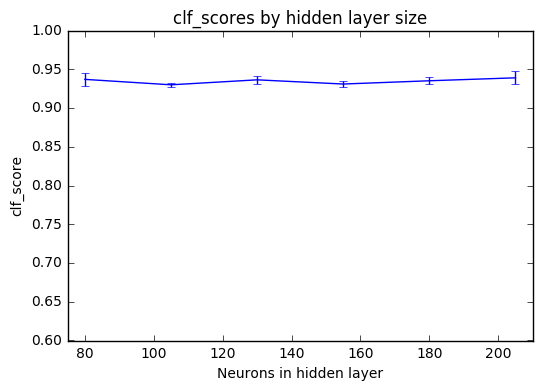

In [96]:
neurons_scores2_avg = list(np.mean(i) for i in neurons_scores2)
neurons_scores2_std = list(np.std(i) for i in neurons_scores2)

plt.errorbar(sizes2, neurons_scores2_avg, yerr=neurons_scores2_std)
plt.title('clf_scores by hidden layer size')
plt.xlabel('Neurons in hidden layer')
plt.ylabel('clf_score')
plt.xlim(75, 210)
plt.ylim(0.6, 1)
plt.show()

Ok, so the answer is no: changing the hidden layer size doesn't matter much beyond 80-100 neurons.

One more quick question is whether more than one hidden layer makes any difference.  Most of the references I've read online suggest that, for many tasks, multiple layers are unnecessary, but again it will be pretty quick to check:

In [16]:
neurons_scores3 = []
timer = clock()
sizes3 = [(100,), (100, 100), (100, 100, 100), (100, 100, 100, 100)]
layers3 = []
neurons3 = []


for h, size in enumerate(sizes3):
    neurons_scores3.append(list())
    layers3.append(list())
    neurons3.append(list())
    clf = MLPClassifier(hidden_layer_sizes=size)
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        neurons_scores3[h].append(clf.score(j.iloc[4001:, 1:], j.iloc[4001:, 0]))    
    print('Number of hidden layer neurons: ', size, '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    layers3[h].append(clf.n_layers_)
    neurons3[h].append(clf.coefs_[k] for k in list(range(len(clf.coefs_))))
    timer = clock()

Number of hidden layer neurons:  (100,) 	Time taken:  72.828  seconds
Number of hidden layer neurons:  (100, 100) 	Time taken:  51.265  seconds
Number of hidden layer neurons:  (100, 100, 100) 	Time taken:  45.214  seconds
Number of hidden layer neurons:  (100, 100, 100, 100) 	Time taken:  44.383  seconds


In [26]:
print(clf.n_layers_)
print(clf.classes_, clf.n_outputs_)
print(len(clf.coefs_), len(clf.coefs_[0]), len(clf.coefs_[1]), len(clf.coefs_[2]), len(clf.coefs_[3]), len(clf.coefs_[4]))
print(list(range(len(clf.coefs_))))
print(len(clf.coefs_[0][1]))

6
[0 1 2 3 4 5 6 7 8 9] 10
5 784 100 100 100 100
[0, 1, 2, 3, 4]
100


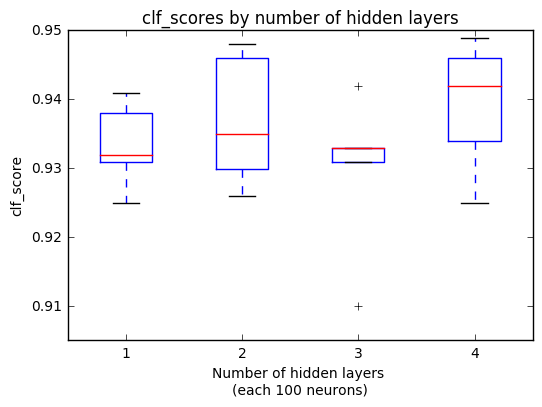

In [27]:
plt.boxplot(neurons_scores3)
plt.title('clf_scores by number of hidden layers')
# plt.xlabel('solver')
plt.ylabel('clf_score')
plt.xticks(range(1,5), list(range(1, 6)))
plt.xlabel('Number of hidden layers \n(each 100 neurons)')
# plt.xlim(75, 115)
# plt.ylim(0.6, 1)
plt.show()

So there's a very marginal improvement made by adding successive hidden layers of neurons.  Surprisingly, the models train faster with more layers, at least on my PC.  I'll stick with 1 layer for now, and revisit whether additional layers provide benefit at the end, after I've finalized the other options that I want to use.

## Part 5: Solver

Next: which solver to use?  

[SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is the standard stochastic gradient descent: you use backpropagation to define the objective function in terms of the derivatives of all the weights in each layer.  Then you start at a random point in the vector space of that derivative, choose a nearby point at random (i.e., altering the weights by small steps at random), see whether it reduces the penalty/gets closer to the desired value from the objective function, and repeat until you can't improve any more (at least, under the rules you've set).

[LBFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) stands for limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm(s?), which is apparently part of a family of such approaches for finding minima that are called quasi-Newtonian.  It appears to differ from gradient descent primarily by the incorporation of second-derivative information about a matrix.  Using an analogy from physics, I might interpret this as attempting to predict the future position of a body by using knowledge about both its acceleration and velocity at some timepoint, rather than just the latter.

[Adam](https://arxiv.org/abs/1412.6980) is an update to/modification of SGD, intended to improve its performance in ways dependent upon particulars I haven't read about yet.

The sklearn docs say:

"The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better."

In [31]:
solvers = ['lbfgs', 'sgd', 'adam']
solver_scores = []
timer = clock()

for h, solver1 in enumerate(solvers):
    solver_scores.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(100,), solver=solver1)
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        solver_scores[h].append(clf.score(j.iloc[4001:, 1:], j.iloc[4001:, 0]))
    print('Solver algorithm used: ', solver1, '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

Solver algorithm used:  lbfgs 	Time taken:  17.765  seconds


C:\Python\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Solver algorithm used:  sgd 	Time taken:  121.547  seconds
Solver algorithm used:  adam 	Time taken:  71.2  seconds


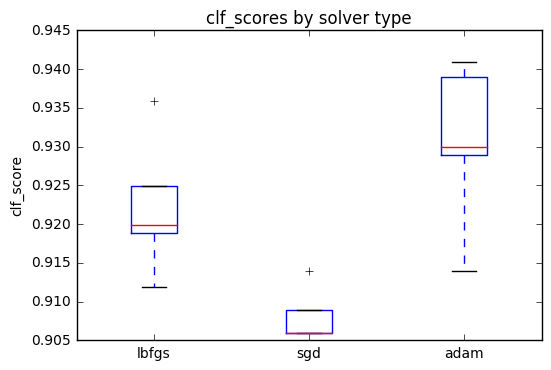

In [32]:
plt.boxplot(solver_scores)
plt.title('clf_scores by solver type')
# plt.xlabel('solver')
plt.ylabel('clf_score')
plt.xticks(range(1,4), (solver for solver in solvers))
# plt.xlim(75, 115)
# plt.ylim(0.6, 1)
plt.show()

Hmm... mixed results.  No clear winner, but a ConvergenceWarning was raised, saying it had hit max iter.  I wonder if I try increasing the max_iter value.  This one is kind of important to get right, because there are multiple other options that only become relevant with one or another solver: sgd involves picking a learning schedule, power_t value, and momentum bool, whereas adam has epsilon and beta values to set.  So I'll retry with a larger training set to ensure that I'm getting the best representation for the choice of solver here.

In [6]:
solvers = ['lbfgs', 'sgd', 'adam']
solver_scores = []
timer = clock()

for h, solver1 in enumerate(solvers):
    solver_scores.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(100,), solver=solver1, max_iter=500)
    for i in range(5):
        j = train3.sample(n=20000)
        clf.fit(j.iloc[0:16000, 1:], j.iloc[0:16000, 0])
        solver_scores[h].append(clf.score(j.iloc[16001:, 1:], j.iloc[16001:, 0]))
    print('Solver algorithm used: ', solver1, '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

Solver algorithm used:  lbfgs 	Time taken:  111.956  seconds


C:\Python\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Solver algorithm used:  sgd 	Time taken:  1038.98  seconds
Solver algorithm used:  adam 	Time taken:  153.253  seconds


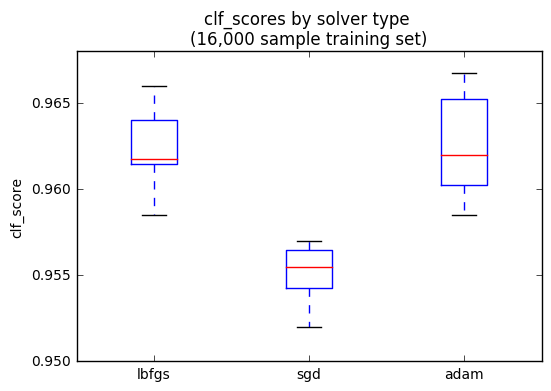

In [7]:
plt.boxplot(solver_scores)
plt.title('clf_scores by solver type \n(16,000 sample training set)')
# plt.xlabel('solver')
plt.ylabel('clf_score')
plt.xticks(range(1,4), (solver for solver in solvers))
# plt.xlim(75, 115)
# plt.ylim(0.6, 1)
plt.show()

Ok, the scores overall improved, but the trend remains roughly the same: sgd is underperforming the other two options (it also took preposterously long to compute: 1038 seconds?).  It might get better, of course, if I optimize the parameters for it, but for simplicity's sake I'll work with adam going forward.

In [ ]:
learning = ['constant', 'invscaling', 'adaptive']
learning_scores = []
timer = clock()

for h, learn in enumerate(learning):
    learning_scores.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(100,), solver='sgd', learning_rate = learn)
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        learning_scores[h].append(clf.score(j.iloc[4001:, 1:], j.iloc[4001:, 0]))
    print('Learning rate scheduler used: ', learn, '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

C:\Python\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Learning rate scheduler used:  constant 	Time taken:  122.83  seconds


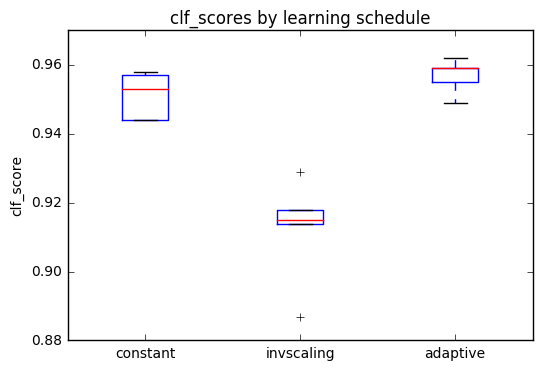

In [27]:
plt.boxplot(learning_scores)
plt.title('clf_scores by learning schedule')
plt.ylabel('clf_score')
plt.xticks(range(1,4), learning)
# plt.xlim(75, 115)
# plt.ylim(0.6, 1)
plt.show()

## Part 6: Max_iter

In order to process more samples in the latter example above, I bumped the maximum iterations allowed while training up from 200 (default) to 500.  Even still, a ConvergenceWarning was raised, but either for the sgd or lbfgs solver run; I'm pretty sure adam didn't trip it.  I don't want to waste time with the remaining tests: how many maximum iterations should be used?

In [9]:
%%time

iterations = list(int(i) for i in (list(np.round(np.logspace(1e-1, 4, num=15)))))
scores_iterations = []
timer = clock()

for h, max1 in enumerate(iterations):
    scores_iterations.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', max_iter=max1)
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        scores_iterations[h].append(clf.score(j.iloc[4001:, 1:], j.iloc[4001:, 0]))
    print('max_iter value used: ', max1, '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

C:\Python\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


max_iter value used:  1 	Time taken:  1.031  seconds
max_iter value used:  2 	Time taken:  1.439  seconds
max_iter value used:  5 	Time taken:  2.843  seconds
max_iter value used:  9 	Time taken:  6.159  seconds
max_iter value used:  16 	Time taken:  8.783  seconds
max_iter value used:  31 	Time taken:  16.885  seconds
max_iter value used:  59 	Time taken:  30.043  seconds
max_iter value used:  112 	Time taken:  51.627  seconds
max_iter value used:  213 	Time taken:  57.26  seconds
max_iter value used:  405 	Time taken:  57.106  seconds
max_iter value used:  769 	Time taken:  57.55  seconds
max_iter value used:  1460 	Time taken:  56.179  seconds
max_iter value used:  2772 	Time taken:  55.666  seconds
max_iter value used:  5265 	Time taken:  54.385  seconds
max_iter value used:  10000 	Time taken:  53.564  seconds
Wall time: 8min 30s


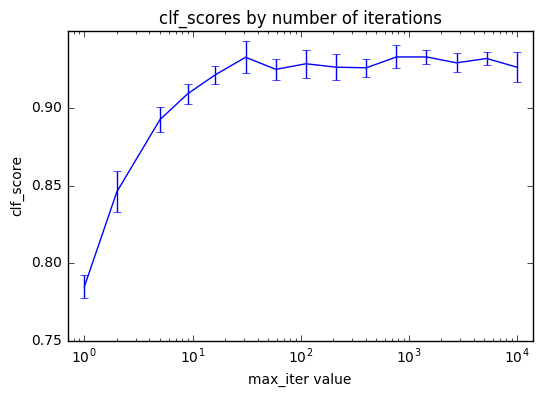

In [17]:
iterations_scores_avg = list(np.mean(i) for i in scores_iterations)
iterations_scores_std = list(np.std(i) for i in scores_iterations)

plt.errorbar(iterations, iterations_scores_avg, yerr=iterations_scores_std)
plt.title('clf_scores by number of iterations')
plt.xlabel('max_iter value')
plt.ylabel('clf_score')
plt.xlim(0.7, 14000)
plt.xscale('log')
# plt.ylim(0.6, 1)
plt.show()

In [16]:
iterations = list(int(i) for i in (list(np.round(np.logspace(1e-1, 4, num=15)))))
print(iterations)
for i, j in zip(iterations, iterations_scores_avg):
    print(i, '\t', j)

[1, 2, 5, 9, 16, 31, 59, 112, 213, 405, 769, 1460, 2772, 5265, 10000]
1 	 0.784984984985
2 	 0.846246246246
5 	 0.892692692693
9 	 0.909309309309
16 	 0.921321321321
31 	 0.932932932933
59 	 0.925125125125
112 	 0.928728728729
213 	 0.926526526527
405 	 0.926126126126
769 	 0.933133133133
1460 	 0.933133133133
2772 	 0.929329329329
5265 	 0.932132132132
10000 	 0.926526526527


Ok, anything more than 30 iterations is overkill, at least for a training set with 4,000 samples.  Yet if I permute other options I might expect slower performance, so I'll build in some wiggle room.  I'll use the default max_iter=200 going forward, and only modify this if I see ConvergenceWarnings.

## Part 7: Activation function

I've been using the default 'relu' activation function so far, and didn't expect that this would make a big difference on the results, but I'll try comparing them briefly here.

In [21]:
activation = ['identity', 'logistic', 'tanh', 'relu']
scores_activation = []
timer = clock()

for h, activation1 in enumerate(activation):
    scores_activation.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', max_iter=200, activation=activation1)
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        scores_activation[h].append(clf.score(j.iloc[4001:5000, 1:], j.iloc[4001:5000, 0]))
    print('Activation function used: ', activation1, '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

Activation function used:  identity 	Time taken:  73.179  seconds
Activation function used:  logistic 	Time taken:  115.182  seconds
Activation function used:  tanh 	Time taken:  64.919  seconds
Activation function used:  relu 	Time taken:  57.626  seconds


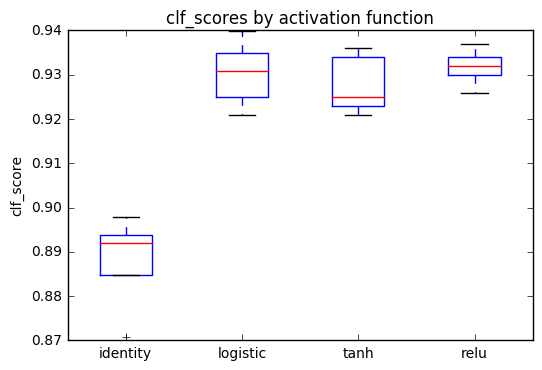

In [22]:
plt.boxplot(scores_activation)
plt.title('clf_scores by activation function')
# plt.xlabel('solver')
plt.ylabel('clf_score')
plt.xticks(range(1,5), activation)
# plt.xlim(75, 115)
# plt.ylim(0.6, 1)
plt.show()

Ok, it's pretty clear that you don't want to use "identity".  It's kind of a tossup between the rest; other than the fact that logistic took significantly longer.  The default, 'relu' setting, works fine and should be kept.

## Part 8: Learning_rate_init

The choice of step sizes for altering the weights while training could be important.  I'll try a few different values.

In [44]:
inits = list(np.logspace(-6, 0, num=15))
scores_inits = []
timer = clock()

for h, init1 in enumerate(inits):
    scores_inits.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', max_iter=200, activation='relu',
                        learning_rate_init=init1)
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        scores_inits[h].append(clf.score(j.iloc[4001:5000, 1:], j.iloc[4001:5000, 0]))
    print('Learning_rate_init value used: ', init1, 
          '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

C:\Python\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Learning_rate_init value used:  1e-06 	Time taken:  120.323  seconds
Learning_rate_init value used:  2.68269579528e-06 	Time taken:  118.777  seconds
Learning_rate_init value used:  7.19685673001e-06 	Time taken:  119.821  seconds
Learning_rate_init value used:  1.93069772888e-05 	Time taken:  119.403  seconds
Learning_rate_init value used:  5.17947467923e-05 	Time taken:  114.857  seconds
Learning_rate_init value used:  0.000138949549437 	Time taken:  117.908  seconds
Learning_rate_init value used:  0.000372759372031 	Time taken:  110.07  seconds
Learning_rate_init value used:  0.001 	Time taken:  56.807  seconds
Learning_rate_init value used:  0.00268269579528 	Time taken:  34.543  seconds
Learning_rate_init value used:  0.00719685673001 	Time taken:  20.555  seconds
Learning_rate_init value used:  0.0193069772888 	Time taken:  13.477  seconds
Learning_rate_init value used:  0.0517947467923 	Time taken:  9.538  seconds
Learning_rate_init value used:  0.138949549437 	Time taken:  10.4

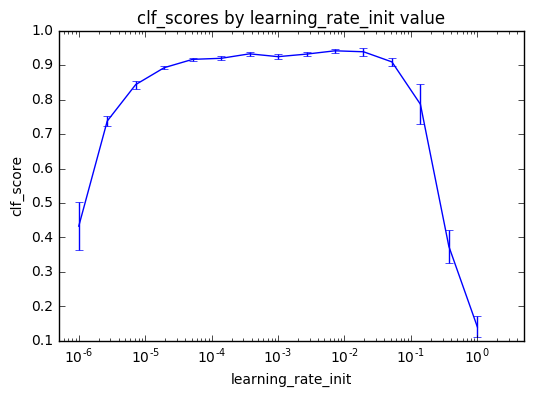

1e-06 	 0.432832832833
2.68269579528e-06 	 0.737937937938
7.19685673001e-06 	 0.843843843844
1.93069772888e-05 	 0.892892892893
5.17947467923e-05 	 0.917117117117
0.000138949549437 	 0.92012012012
0.000372759372031 	 0.933133133133
0.001 	 0.924924924925
0.00268269579528 	 0.932332332332
0.00719685673001 	 0.941941941942
0.0193069772888 	 0.939139139139
0.0517947467923 	 0.90970970971
0.138949549437 	 0.786786786787
0.372759372031 	 0.373973973974
1.0 	 0.140540540541


In [45]:
inits_avg = list(np.mean(i) for i in scores_inits)
inits_std = list(np.std(i) for i in scores_inits)

plt.errorbar(inits, inits_avg, yerr=inits_std)
plt.title('clf_scores by learning_rate_init value')
plt.ylabel('clf_score')
plt.xlabel('learning_rate_init')
plt.xscale('log')
plt.xlim(5e-7, 5)
plt.show()

for i, j in zip(inits, inits_avg):
    print(i, '\t', j)

Ok, values close to 0.1 and 0.2 performed best; there's a big drop-off in scores for any step of larger size.  The default value of 0.001 is definitely acceptable, but 0.01 is slightly better; that's what I'll use going forward.

## Part 9: Solver-specific values

If I were using sgd as the solver, the next variables to maybe try would be changing the learning rate from constant to adaptive.  But with adam as the flagship solver for this run, I'm more concerned about whether choices of values for beta and epsilon may make some difference, and finally whether or not to enable early stopping.

In [26]:
beta1s = list(np.logspace(-1, -1e-3, num=10))
scores_beta1s = []
timer = clock()

for h, beta1 in enumerate(beta1s):
    scores_beta1s.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', max_iter=200, activation='relu',
                        learning_rate_init=0.01, beta_1=beta1)
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        scores_beta1s[h].append(clf.score(j.iloc[4001:, 1:], j.iloc[4001:, 0]))
    print('Beta1 value used: ', beta1, 
          '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

Learning_rate_init value used:  0.1 	Time taken:  17.894  seconds
Learning_rate_init value used:  0.129121927361 	Time taken:  19.085  seconds
Learning_rate_init value used:  0.166724721255 	Time taken:  19.263  seconds
Learning_rate_init value used:  0.215278173472 	Time taken:  17.606  seconds
Learning_rate_init value used:  0.277971326776 	Time taken:  20.154  seconds
Learning_rate_init value used:  0.358921934645 	Time taken:  18.25  seconds
Learning_rate_init value used:  0.463446919736 	Time taken:  17.3  seconds
Learning_rate_init value used:  0.59841159506 	Time taken:  17.982  seconds
Learning_rate_init value used:  0.772680585096 	Time taken:  14.987  seconds
Learning_rate_init value used:  0.997700063823 	Time taken:  14.474  seconds


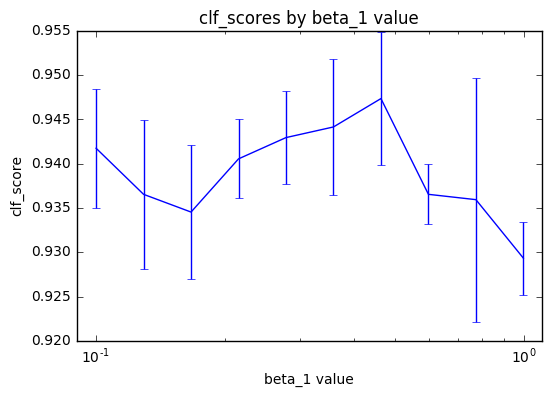

0.1 	 0.941741741742
0.129121927361 	 0.936536536537
0.166724721255 	 0.934534534535
0.215278173472 	 0.940540540541
0.277971326776 	 0.942942942943
0.358921934645 	 0.944144144144
0.463446919736 	 0.947347347347
0.59841159506 	 0.936536536537
0.772680585096 	 0.935935935936
0.997700063823 	 0.929329329329


In [29]:
beta1_avg = list(np.mean(i) for i in scores_beta1s)
beta1_std = list(np.std(i) for i in scores_beta1s)

plt.errorbar(beta1s, beta1_avg, yerr=beta1_std)
plt.title('clf_scores by beta_1 value')
plt.ylabel('clf_score')
plt.xlabel('beta_1 value')
plt.xscale('log')
plt.xlim(9e-2, 1.1)
plt.show()

for i, j in zip(beta1s, beta1_avg):
    print(i, '\t', j)

Ok, so no huge difference overall; 0.5 or so is fine.

In [5]:
beta1s = list(np.linspace(0.3, 0.6, num=10))
scores_beta1s = []
timer = clock()

for h, beta1 in enumerate(beta1s):
    scores_beta1s.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', max_iter=200, activation='relu',
                        learning_rate_init=0.01, beta_1=beta1)
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        scores_beta1s[h].append(clf.score(j.iloc[4001:, 1:], j.iloc[4001:, 0]))
    print('Beta1 value used: ', beta1, 
          '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

Beta1 value used:  0.3 	Time taken:  15.603  seconds
Beta1 value used:  0.333333333333 	Time taken:  17.594  seconds
Beta1 value used:  0.366666666667 	Time taken:  18.084  seconds
Beta1 value used:  0.4 	Time taken:  18.371  seconds
Beta1 value used:  0.433333333333 	Time taken:  18.465  seconds
Beta1 value used:  0.466666666667 	Time taken:  18.314  seconds
Beta1 value used:  0.5 	Time taken:  15.809  seconds
Beta1 value used:  0.533333333333 	Time taken:  15.296  seconds
Beta1 value used:  0.566666666667 	Time taken:  16.477  seconds
Beta1 value used:  0.6 	Time taken:  17.225  seconds


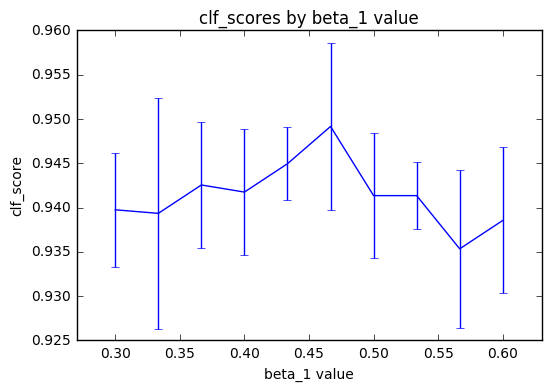

0.3 	 0.93973973974
0.333333333333 	 0.939339339339
0.366666666667 	 0.942542542543
0.4 	 0.941741741742
0.433333333333 	 0.944944944945
0.466666666667 	 0.949149149149
0.5 	 0.941341341341
0.533333333333 	 0.941341341341
0.566666666667 	 0.935335335335
0.6 	 0.938538538539


In [8]:
beta1_avg = list(np.mean(i) for i in scores_beta1s)
beta1_std = list(np.std(i) for i in scores_beta1s)

plt.errorbar(beta1s, beta1_avg, yerr=beta1_std)
plt.title('clf_scores by beta_1 value')
plt.ylabel('clf_score')
plt.xlabel('beta_1 value')
# plt.xscale('log')
plt.xlim(0.27, 0.63)
plt.show()

for i, j in zip(beta1s, beta1_avg):
    print(i, '\t', j)

Eh, no clear winner in that range.  The scores are all between 0.93 and 0.96.  0.45 should be fine for beta1.

In [9]:
beta2s = list(np.logspace(-1, -1e-5, num=10))
scores_beta2s = []
timer = clock()

for h, beta2 in enumerate(beta2s):
    scores_beta2s.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', max_iter=200, activation='relu',
                        learning_rate_init=0.01, beta_1=0.45, beta_2=beta2)
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        scores_beta2s[h].append(clf.score(j.iloc[4001:, 1:], j.iloc[4001:, 0]))
    print('Beta_2 value used: ', beta2, 
          '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

Beta_2 value used:  0.1 	Time taken:  7.154  seconds
Beta_2 value used:  0.129154636068 	Time taken:  7.871  seconds
Beta_2 value used:  0.166809200179 	Time taken:  11.195  seconds
Beta_2 value used:  0.21544181542 	Time taken:  8.099  seconds
Beta_2 value used:  0.278253092644 	Time taken:  10.392  seconds
Beta_2 value used:  0.359376769153 	Time taken:  10.889  seconds
Beta_2 value used:  0.464151758314 	Time taken:  11.458  seconds
Beta_2 value used:  0.599473514255 	Time taken:  11.322  seconds
Beta_2 value used:  0.774247835661 	Time taken:  10.548  seconds
Beta_2 value used:  0.999976974414 	Time taken:  15.533  seconds


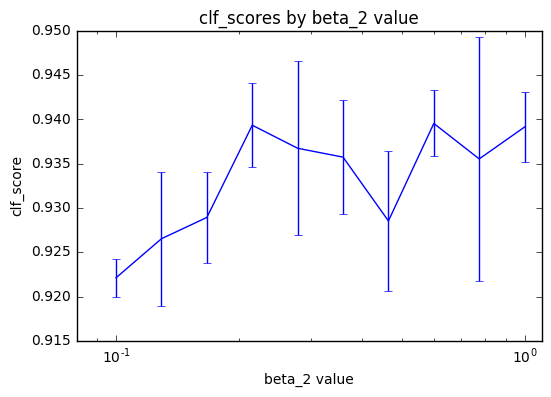

0.1 	 0.922122122122
0.129154636068 	 0.926526526527
0.166809200179 	 0.928928928929
0.21544181542 	 0.939339339339
0.278253092644 	 0.936736736737
0.359376769153 	 0.935735735736
0.464151758314 	 0.928528528529
0.599473514255 	 0.93953953954
0.774247835661 	 0.935535535536
0.999976974414 	 0.939139139139


In [10]:
beta2_avg = list(np.mean(i) for i in scores_beta2s)
beta2_std = list(np.std(i) for i in scores_beta2s)

plt.errorbar(beta2s, beta2_avg, yerr=beta2_std)
plt.title('clf_scores by beta_2 value')
plt.ylabel('clf_score')
plt.xlabel('beta_2 value')
plt.xscale('log')
plt.xlim(0.08, 1.1)
plt.show()

for i, j in zip(beta2s, beta2_avg):
    print(i, '\t', j)

Not a big effect, but higher values seem better, overall.  The default of 0.999 is probably fine.

In [11]:
epsilons = list(np.logspace(-10, -1, num=10))
scores_epsilons = []
timer = clock()

for h, epsilon1 in enumerate(epsilons):
    scores_epsilons.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', max_iter=200, activation='relu',
                        learning_rate_init=0.01, beta_1=0.45, beta_2=0.999, epsilon=epsilon1)
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        scores_epsilons[h].append(clf.score(j.iloc[4001:, 1:], j.iloc[4001:, 0]))
    print('Epsilon value used: ', epsilon1, 
          '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

Epsilon value used:  1e-10 	Time taken:  19.212  seconds
Epsilon value used:  1e-09 	Time taken:  17.7  seconds
Epsilon value used:  1e-08 	Time taken:  18.326  seconds
Epsilon value used:  1e-07 	Time taken:  17.77  seconds
Epsilon value used:  1e-06 	Time taken:  18.24  seconds
Epsilon value used:  1e-05 	Time taken:  18.639  seconds
Epsilon value used:  0.0001 	Time taken:  21.418  seconds
Epsilon value used:  0.001 	Time taken:  25.25  seconds
Epsilon value used:  0.01 	Time taken:  52.173  seconds


C:\Python\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Epsilon value used:  0.1 	Time taken:  117.198  seconds


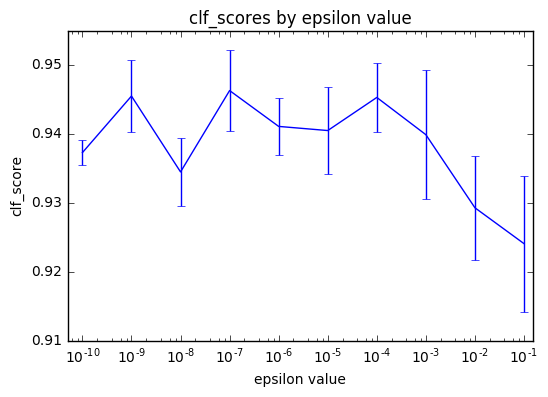

1e-10 	 0.937337337337
1e-09 	 0.945545545546
1e-08 	 0.934534534535
1e-07 	 0.946346346346
1e-06 	 0.941141141141
1e-05 	 0.940540540541
0.0001 	 0.945345345345
0.001 	 0.93993993994
0.01 	 0.929329329329
0.1 	 0.924124124124


In [12]:
epsilon_avg = list(np.mean(i) for i in scores_epsilons)
epsilon_std = list(np.std(i) for i in scores_epsilons)

plt.errorbar(epsilons, epsilon_avg, yerr=epsilon_std)
plt.title('clf_scores by epsilon value')
plt.ylabel('clf_score')
plt.xlabel('epsilon value')
plt.xscale('log')
plt.xlim(5e-11, 0.15)
plt.show()

for i, j in zip(epsilons, epsilon_avg):
    print(i, '\t', j)

Again: no huge diff; we're still seeing scores lingering around 0.94.  But again, I'll take the max score seen here:1e-7 will do.

## Part 10: Everything else

I'll conclude with permuting the alpha, tol, and learning_rate_init values, too (unless any of the runs ends up taking too long).  I foresee very little chance that any will perform much better when tweaked from their current settings, but it will be quick to check that.  Each will need a log range:

In [13]:
alphas = list(np.logspace(-6, -1, num=15))
scores_alphas = []
timer = clock()

for h, alpha1 in enumerate(alphas):
    scores_alphas.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', max_iter=200, activation='relu',
                        learning_rate_init=0.01, beta_1=0.45, beta_2=0.999, epsilon=1e-7, alpha=alpha1)
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        scores_alphas[h].append(clf.score(j.iloc[4001:5000, 1:], j.iloc[4001:5000, 0]))
    print('Alpha value used: ', alpha1, '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

Alpha value used:  1e-06 	Time taken:  19.88  seconds
Alpha value used:  2.27584592607e-06 	Time taken:  22.437  seconds
Alpha value used:  5.17947467923e-06 	Time taken:  21.96  seconds
Alpha value used:  1.17876863479e-05 	Time taken:  20.018  seconds
Alpha value used:  2.68269579528e-05 	Time taken:  18.857  seconds
Alpha value used:  6.10540229659e-05 	Time taken:  18.767  seconds
Alpha value used:  0.000138949549437 	Time taken:  20.11  seconds
Alpha value used:  0.000316227766017 	Time taken:  19.724  seconds
Alpha value used:  0.000719685673001 	Time taken:  20.443  seconds
Alpha value used:  0.00163789370695 	Time taken:  20.939  seconds
Alpha value used:  0.00372759372031 	Time taken:  28.804  seconds
Alpha value used:  0.00848342898244 	Time taken:  35.124  seconds
Alpha value used:  0.0193069772888 	Time taken:  23.819  seconds
Alpha value used:  0.0439397056076 	Time taken:  13.927  seconds
Alpha value used:  0.1 	Time taken:  9.455  seconds


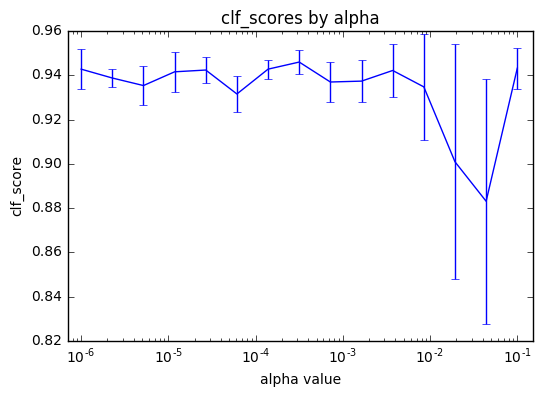

1e-06 	 0.942742742743
2.27584592607e-06 	 0.938738738739
5.17947467923e-06 	 0.935335335335
1.17876863479e-05 	 0.941541541542
2.68269579528e-05 	 0.942342342342
6.10540229659e-05 	 0.931531531532
0.000138949549437 	 0.942742742743
0.000316227766017 	 0.945945945946
0.000719685673001 	 0.936936936937
0.00163789370695 	 0.937337337337
0.00372759372031 	 0.942142142142
0.00848342898244 	 0.934734734735
0.0193069772888 	 0.900900900901
0.0439397056076 	 0.883083083083
0.1 	 0.943143143143


In [21]:
alphas_avg = list(np.mean(i) for i in scores_alphas)
alphas_std = list(np.std(i) for i in scores_alphas)

plt.errorbar(alphas, alphas_avg, yerr=alphas_std)
plt.title('clf_scores by alpha')
plt.ylabel('clf_score')
plt.xlabel('alpha value')
plt.xscale('log')
plt.xlim(7e-7, 0.15)
plt.show()

for i, j in zip(alphas, alphas_avg):
    print(i, '\t', j)

Ok, the higher alpha values are clearly poorer (although 0.1 appears to be ok, for some reason); it's safest to stick with something in the middle of that range, I think: alpha=0.0003, which is very close to the default value.

In [22]:
tols = list(np.logspace(-6, -3, num=8))
scores_tols = []
timer = clock()

for h, tol1 in enumerate(tols):
    scores_tols.append(list())
    clf = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', max_iter=200, activation='relu',
                        learning_rate_init=0.01, beta_1=0.45, beta_2=0.999, epsilon=1e-7, alpha=3e-4, tol=tol1)
    for i in range(5):
        j = train3.sample(n=5000)
        clf.fit(j.iloc[0:4000, 1:], j.iloc[0:4000, 0])
        scores_tols[h].append(clf.score(j.iloc[4001:, 1:], j.iloc[4001:, 0]))
    print('Tolerance value used: ', tol1, '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    timer = clock()

C:\Python\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Tolerance value used:  1e-06 	Time taken:  148.315  seconds
Tolerance value used:  2.68269579528e-06 	Time taken:  81.404  seconds
Tolerance value used:  7.19685673001e-06 	Time taken:  56.064  seconds
Tolerance value used:  1.93069772888e-05 	Time taken:  35.514  seconds
Tolerance value used:  5.17947467923e-05 	Time taken:  28.044  seconds
Tolerance value used:  0.000138949549437 	Time taken:  19.961  seconds
Tolerance value used:  0.000372759372031 	Time taken:  14.097  seconds
Tolerance value used:  0.001 	Time taken:  11.142  seconds


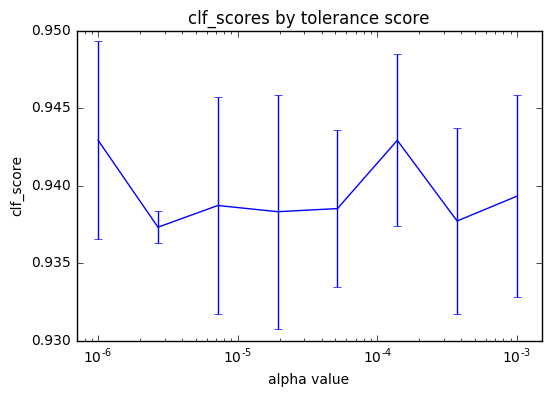

In [24]:
tols_avg = list(np.mean(i) for i in scores_tols)
tols_std = list(np.std(i) for i in scores_tols)

plt.errorbar(tols, tols_avg, yerr=tols_std)
plt.title('clf_scores by tolerance score')
plt.ylabel('clf_score')
plt.xlabel('alpha value')
plt.xscale('log')
plt.xlim(7e-7, 0.0015)
plt.show()

Huh.  The choice of tol values over a pretty broad range made surprisingly little difference in output model scores.  In any case, 1e-4 appears to be as good a choice as any other.

## Part 11: Hidden layers, revisited

Ok, I've permuted all of the variables I want to, and converged on values startlingly similar to the defaults; the output model score hasn't budged much.  This outcome is kind of depressing, but it is at least somewhat reassuring in that it suggests that a simple neural network approach as implemented in sklearn is a very robust way to score around 94% accuracy in classifying MNIST digit data with 4,000 training samples.  The ".score()" method (outputting accuracy) is built-in to the MLPClassifier module, but perhaps I should've been looking for alternate metrics, such as recall and precision along the way?  For now, I'll go with the settings I have determined to work best from the above, and re-run the comparison of one to multiple hidden layers (performed in part 4), with a larger subset of training data, in anticipation of finalizing the project and submitting a model.

In [29]:
neurons_scores3 = []
timer = clock()
sizes3 = [(100,), (100, 100), (100, 100, 100), (100, 100, 100, 100)]
layers3 = []
neurons3 = []


for h, size in enumerate(sizes3):
    neurons_scores3.append(list())
    layers3.append(list())
    neurons3.append(list())
    clf = MLPClassifier(hidden_layer_sizes=size, solver='adam', max_iter=200, activation='relu',
                        learning_rate_init=0.01, beta_1=0.45, beta_2=0.999, epsilon=1e-7, alpha=3e-4, tol=1e-4)

    for i in range(5):
        j = train3.sample(frac=1)
        clf.fit(j.iloc[0:30000, 1:], j.iloc[0:30000, 0])
        neurons_scores3[h].append(clf.score(j.iloc[30001:, 1:], j.iloc[30001:, 0]))    
    print('Number of hidden layer neurons: ', size, '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    layers3[h].append(clf.n_layers_)
    neurons3[h].append(clf.coefs_[k] for k in list(range(len(clf.coefs_))))
    timer = clock()

Number of hidden layer neurons:  (100,) 	Time taken:  97.02  seconds
Number of hidden layer neurons:  (100, 100) 	Time taken:  99.331  seconds
Number of hidden layer neurons:  (100, 100, 100) 	Time taken:  125.985  seconds
Number of hidden layer neurons:  (100, 100, 100, 100) 	Time taken:  138.879  seconds


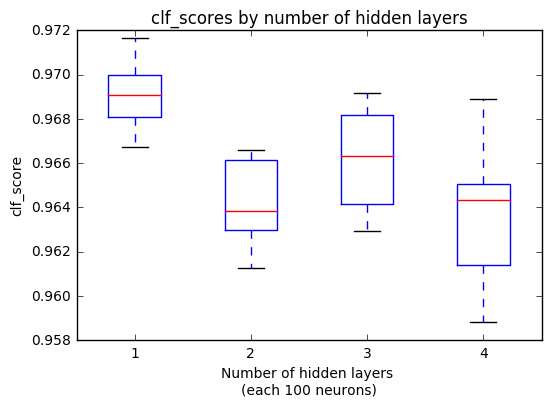

In [31]:
plt.boxplot(neurons_scores3)
plt.title('clf_scores by number of hidden layers')
# plt.xlabel('solver')
plt.ylabel('clf_score')
plt.xticks(range(1,5), list(range(1, 6)))
plt.xlabel('Number of hidden layers \n(each 100 neurons)')
# plt.xlim(75, 115)
# plt.ylim(0.6, 1)
plt.show()

Well, that's a little surprising.  While the number of hidden layers made little difference with these settings and this large a training set, it actually did best with only one layer.  Another variable that might make a difference is fan out: should there be fewer neurons in the later hidden layers?  I tried the equal number in each layer because it was easiest.  Anyways, I'm not particularly inclined to test it here.  A mean accuracy of ~97% apparently isn't bad for a simple neural network (although it's very little improved from the starting point of this notebook, with the default settings, and very little improved over my random forest trial).

Actually; that's a good sanity check to perform: compare my "optimized" arguments (above) with the same number of samples, training with the default hyperparameters in everything (below).  Have I improved anything at all?

In [32]:
neurons_scores3 = []
timer = clock()
sizes3 = [(100,), (100, 100), (100, 100, 100), (100, 100, 100, 100)]
layers3 = []
neurons3 = []


for h, size in enumerate(sizes3):
    neurons_scores3.append(list())
    layers3.append(list())
    neurons3.append(list())
    clf = MLPClassifier()

    for i in range(5):
        j = train3.sample(frac=1)
        clf.fit(j.iloc[0:30000, 1:], j.iloc[0:30000, 0])
        neurons_scores3[h].append(clf.score(j.iloc[30001:, 1:], j.iloc[30001:, 0]))    
    print('Number of hidden layer neurons: ', size, '\tTime taken: ', round(clock() - timer, 3), ' seconds')
    layers3[h].append(clf.n_layers_)
    neurons3[h].append(clf.coefs_[k] for k in list(range(len(clf.coefs_))))
    timer = clock()

Number of hidden layer neurons:  (100,) 	Time taken:  327.562  seconds
Number of hidden layer neurons:  (100, 100) 	Time taken:  309.575  seconds
Number of hidden layer neurons:  (100, 100, 100) 	Time taken:  298.614  seconds
Number of hidden layer neurons:  (100, 100, 100, 100) 	Time taken:  285.098  seconds


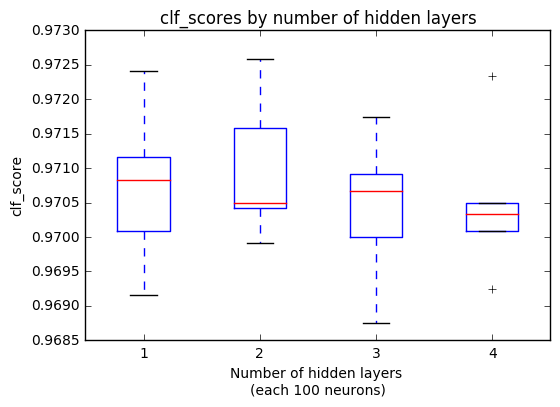

In [33]:
plt.boxplot(neurons_scores3)
plt.title('clf_scores by number of hidden layers')
# plt.xlabel('solver')
plt.ylabel('clf_score')
plt.xticks(range(1,5), list(range(1, 6)))
plt.xlabel('Number of hidden layers \n(each 100 neurons)')
# plt.xlim(75, 115)
# plt.ylim(0.6, 1)
plt.show()

Well, that's a big negatory.  The highest mean score with my "optimized" hyperparameters is about 96.9%; the highest mean with default parameters is 97.08%.  So there's really no great difference, and my results are slightly worse.  This surprises me personally, but it was still kind of a worthwhile exercise.  Like I said: the biggest takeaway is that, at least within the range of conditions I tried, MLPClassifier is pretty robust to hyperparameter permutation: the defaults work as well as anything I picked.

## Part 12: Wrapping up

While there's no great reason to expect that the individual options I've chosen based on their performance in isolation will present a best solution in conjunction, it's the best option I have right now to just throw them together, train on a large dataset, and prepare for submission.

So there you have it.  After lots of permuting options within MLPClassifier, building models, and visualizing their scores, the only values that I ended up changing from the default were learning_rate_init, beta_1, epsilon, and alpha, and all of these were by relatively small amounts.  The difference from the default output isn't that great, either.

## Part 13: Oh, wait.

After all that work looking at how these hyperparameters compare one-by-one, a friend told me about a tool called [grid search](http://scikit-learn.org/stable/modules/grid_search.html) available within sklearn, which automates the process of searching through a subset of hyperparameter space and comparing results, usually with [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) of the results using another sklearn tool (instead of the manual partition of the randomly sampled data which I have used above, which is presumably less robust).  A slightly similar [example](http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html#sphx-glr-auto-examples-model-selection-grid-search-digits-py) is available in the docs.

I'm sure that the trials I ran above will take a prohibitively long time on my laptop to compare exhaustively in an all-vs-all comparison, so I'll try the related function RandomizedSearchCV, which drastically reduces the search space among hyperparameters by sampling.  Also, since I don't really expect a performance boost relative to my own arduous approach above, I'll just run a greatly pared-down hyperparameter space to demonstrate this tool's use.

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

sizes3 = [(100,), (100, 100), (100, 100, 100), (100, 100, 100, 100)]
tols = list(np.logspace(-6, -3, num=8))
solvers = ['lbfgs', 'adam']
activation = ['logistic', 'tanh', 'relu']
learning = ['constant', 'invscaling', 'adaptive']

First, re-run the default network, to demonstrate time and accuracy:

In [12]:
%%time

clf = MLPClassifier()
clf.fit(train3.iloc[0:4000, 1:], train3.iloc[0:4000, 0])
print(clf.score(train3.iloc[4001:5000, 1:], train3.iloc[4001:5000, 0]))

0.938938938939
CPU times: user 37.9 s, sys: 5.55 s, total: 43.4 s
Wall time: 23.1 s


In [13]:
print(clf)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


Then, run RandomizedSearchCV, permuting just neural network sizes, solvers, and activation functions.  I'll just try 5 iterations (with 5 cross-validations each, so at least 25x times the default runtime above; maybe 10 min).  5 iterations isn't nearly enough to give a fair comparison between 4 * 2 * 3 hyperparameter space represented by these three arguments, but it'll at least show how this tool works.

In [14]:
param_distributions = dict(activation=activation, hidden_layer_sizes=sizes3, solver=solvers)
clf = RandomizedSearchCV(MLPClassifier(), param_distributions=param_distributions, 
                         cv=5, scoring='accuracy', n_iter=5, n_jobs=-1)
X = train3.iloc[:, 1:]
y = train3.iloc[:, 0]

In [15]:
%%time

clf.fit(X, y=y)

CPU times: user 3min 18s, sys: 34.6 s, total: 3min 53s
Wall time: 1h 22min 58s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100), (100, 100, 100, 100)], 'solver': ['lbfgs', 'adam'], 'activation': ['logistic', 'tanh', 'relu']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

In [16]:
print(clf.best_params_, '\n', clf.best_score_, '\n', clf.best_estimator_)

{'hidden_layer_sizes': (100,), 'solver': 'adam', 'activation': 'relu'} 
 0.971452380952 
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


Ok, that took over an hour on my ancient mac, and found that the best outcome was with the default single hidden layer, the default 'relu' activation function, and the default 'adam' solver.  This supports my previous conclusion that the default settings still seem best for this data set, and the accuracy is still hovering around 97%.  Just to be thorough, I'll read in the results to pandas, see what combinations of these arguments it tried, and whether the accuracy scores varied much across them:

In [20]:
clf_results = pd.DataFrame.from_dict(data=clf.cv_results_)
print(clf_results.shape)
clf_results.head()

(5, 23)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_activation,param_hidden_layer_sizes,param_solver,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,819.061999,0.549951,0.970024,0.999958,tanh,"(100, 100, 100, 100)",lbfgs,"{'hidden_layer_sizes': (100, 100, 100, 100), '...",3,0.970256,...,0.969282,0.999970,0.968917,0.999940,0.970581,0.999940,514.444409,0.077452,0.000807,0.000024
1,255.224919,0.183490,0.971452,0.999244,relu,"(100,)",adam,"{'hidden_layer_sizes': (100,), 'solver': 'adam...",1,0.972397,...,0.968687,0.999851,0.970942,1.000000,0.973678,1.000000,45.532469,0.023168,0.001659,0.001439
2,154.178520,0.286214,0.971405,0.997815,relu,"(100, 100, 100)",adam,"{'hidden_layer_sizes': (100, 100, 100), 'solve...",2,0.969899,...,0.971187,0.999077,0.968798,0.997976,0.974035,0.998482,23.128809,0.047749,0.001945,0.001338
3,224.134807,0.319989,0.965429,0.999905,logistic,"(100,)",lbfgs,"{'hidden_layer_sizes': (100,), 'solver': 'lbfg...",4,0.968709,...,0.964401,0.999911,0.962963,0.999940,0.966293,0.999940,44.772799,0.079272,0.001953,0.000044
4,421.749656,0.356897,0.964976,0.999786,logistic,"(100, 100)",lbfgs,"{'hidden_layer_sizes': (100, 100), 'solver': '...",5,0.968590,...,0.965472,0.999911,0.963558,0.999762,0.964745,0.999792,104.662181,0.108437,0.002071,0.000115


Ok, so none of them made a big difference in performance.  I think I've beaten this dead horse for long enough.  Time to train the default MLPClassifier on the full training set, predict test values, and submit.

In [22]:
%%time

clf = MLPClassifier()
clf_final = clf.fit(X, y)

CPU times: user 2min 46s, sys: 29.6 s, total: 3min 16s
Wall time: 1min 59s


In [28]:
results=clf_final.predict(test2)

test2['Label'] = pd.Series(results).astype(int)
test2['ImageId'] = test2.index +1
sub = test2[['ImageId','Label']]

sub.to_csv('digit_nn_submission.csv', index=False)

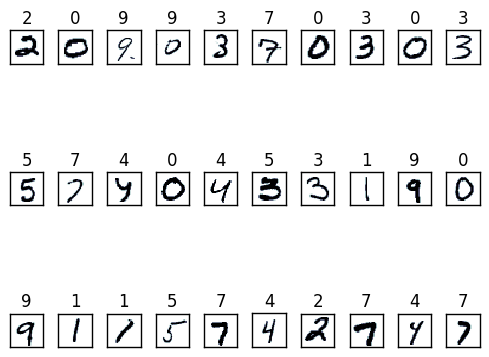

In [31]:
# plot some of the numbers
plt.figure(figsize=(5, 5))
for digit in range(0,30):
    plt.subplot(3,10,digit+1)
    grid_data = test2.iloc[digit,:-2].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "bone_r", label=train.iloc[digit,0])
    title = int(test2.iloc[digit,-2])
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

Huh.  Just like the random forest, they both seem to think the fourth digit is a nine, when I'm betting by eyeballing it that it should be a zero.  Also, the 16th digit is given as a 5 here, when it probably should be a 3.  Oh well.  Submit!

Update: Kaggle says it's slightly better than the random forest model:
"Your submission scored 0.97114, which is an improvement of your previous score of 0.96657. Great job!"

I'm so glad those hours of work finally paid off.

Next up: dimensional reduction and support vector machines!